# Measuring Bias in a Regression Model

In this notebook, we audit a regression system for bias using the holisticai library. We will load and explore a dataset, train a regression model, and audit the model using the library's bias metrics. All questions and tasks are bolded and in red.

### 0 - Importing modules and loading the data

We begin by loading the dataset. For this milestone, we will be using the 'Student Performance Dataset' from the UC Irvine Machine Learning Repository and loading it directly from the holisticai library. The dataset captures the performance of students in two Portuguese secondary schools. 

In [ ]:
# install the holisticai library
!pip install holisticai

In [ ]:
# import regression bias metrics
from holisticai.bias.metrics import statistical_parity_regression
from holisticai.bias.metrics import disparate_impact_regression
from holisticai.bias.metrics import mae_ratio
from holisticai.bias.metrics import rmse_ratio
from holisticai.bias.metrics import regression_bias_metrics

In [1]:
# Base Imports
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

# import dataset
from holisticai.datasets import load_student

# import plotting functions
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import distribution_plot
from holisticai.bias.plots import success_rate_curves

In [2]:
# load dataset into a dataframe
df = load_student()['frame']

### 1- Exploring the dataset

Now that we've loaded the data, let's explore it using pandas.

In [3]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,...,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9.0,9.0,9.0
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,...,2.0,4.0,5.0,3.0,4.0,2.0,3.0,14.0,16.0,16.0
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,...,5.0,5.0,3.0,3.0,3.0,3.0,3.0,10.0,8.0,7.0
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,...,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11.0,12.0,10.0


In [4]:
df.columns.values

array(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3'], dtype=object)

From the previous two cells, we see that there are 395 data points and 33 attributes. There are several sensitive attributes in the data including 'sex', 'address', 'Mjob' (mother's job), and 'Fjob' (father's job). The last three attributes, G1, G2 and G3, are the level the student achieved in periods 1,2 and 3 respectively. We will train a regression model to predict the value of G3. Next, we will explore the distribution of various features using the plotting functions in the library.

<AxesSubplot:xlabel='G3', ylabel='Probability'>

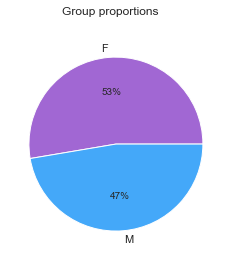

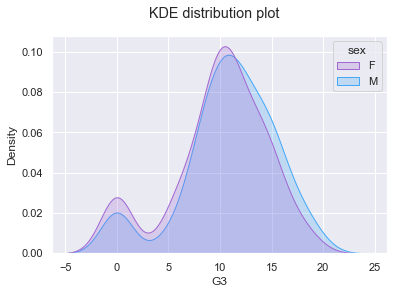

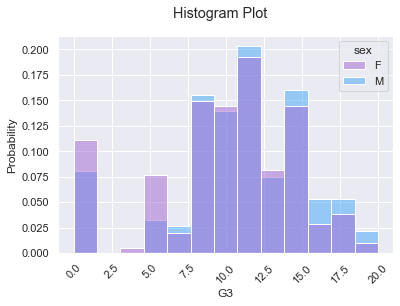

In [5]:
# use the pie plot function to explore the balance of 'sex' attribute
group_pie_plot(df['sex'])

# distribution of grades for male and female students
distribution_plot(df['G3'], df['sex'])
histogram_plot(df['G3'], df['sex'])

The pie chart above shows the distribution of Male (M) and Female (F) students in the data. We see that the data is relatively balanced with respect to 'sex'. Using the KDE and Histogram we can see the distribution of grades in the third period, G3, for both Female and Male students. The distributions are fairly similar for both sexes but show a slight difference in the range of 12 to 20 where male students have a higher density. 

We can also look at the distribution of grades amongst the different jobs students' Fathers have (Fjob).

<AxesSubplot:xlabel='G3', ylabel='Density'>

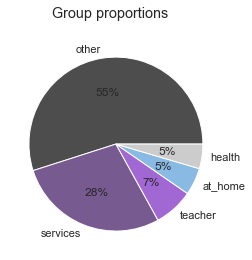

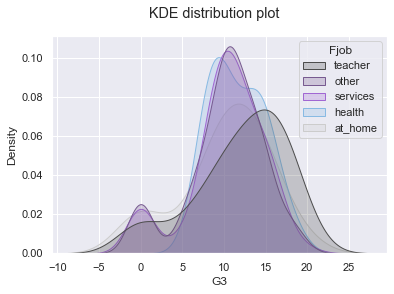

In [6]:
# use the pie plot function to explore the balance of 'Fjob' attribute
group_pie_plot(df['Fjob'])
# distribution of grades for male an female
distribution_plot(df['G3'], df['Fjob'])

The Father’s job attribute is the one that shows the most difference in the densities of grades. For instance, we observe students with a father working in health have a higher density at higher grades. This can be seen in the success rate curves below. A 'success' means the student exceeds the given grade threshold. The plots show success rates as a function of threshold for different subgroups of the population: Father’s job in [‘at_home’, ‘health’, ‘teacher’]. We can observe that student’s with a parent as a teacher are more likely to exceed high thresholds than other groups. We can observe that students with a parent as a teacher (light grey curve) are more likely to exceed high thresholds than other groups.

<AxesSubplot:xlabel='Score'>

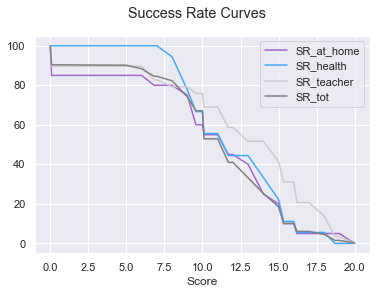

In [7]:
p_attr = np.array(df['Fjob'])

y = np.array(df['G3'])

success_rate_curves(p_attr, y, groups=['at_home', 'health', 'teacher'])

<font color='red'>  **Task 1**
- **Create a pie plot, KDE distribition, and histogram plot for the 'address' attribute.**
<font >

<AxesSubplot:xlabel='G3', ylabel='Probability'>

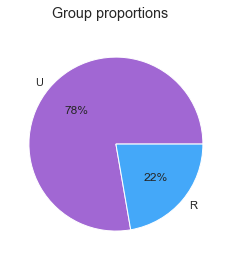

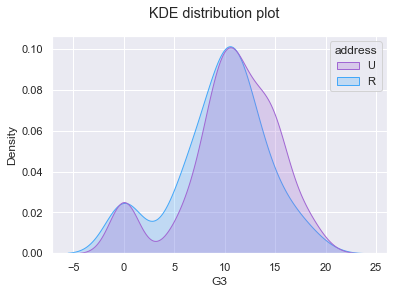

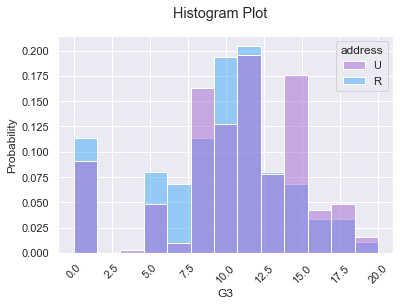

In [8]:
# use the pie plot function to explore the balance of 'address' attribute

# TODO

# distribution of grades for students living urban and rural homes

# TODO

From the pie chart, you should see that there are significantly more students living in urban homes (307) compared to rural homes (88). We also see a difference in density between the two groups. 

<font color='red'> **Question 1**
- **What does the KDE plot tell you about the distribution of grades among students living in urban and rural areas?**
<font > 

Answer:

### 2 - Pre-processing the data and training the model

In this next section, we are going to prepare the data for the training of a regression model. We will use sklearn's linear regression model as our model of choice, and we use its train_test_split function to split our dataset. Note, we do not want to include protected attributes in the training so we will remove 'sex', 'address', 'Mjob', and 'Fjob' from the features during training and inference. We also remove each of the grade attributes as we would like to predict G3 and it is highly correlated with G1 and G2. For the attributes we want to train the model o, we use one-hot encoding for each of them. After training, we will evaluate the model's performance overall and then audit it for bias.

In [9]:
# we don't want to encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['G3', 'G2', 'G1']

# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns

    df = df.rename(str, axis='columns')
    return df

In [10]:
# Load, preprocess and split for training and testing
data = df
preproc_data = preprocess_data(data, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.3, random_state=42)

# G3 is the students final grade (drop G2 and G1 as well because highly correlated with G3)
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['G3']
y_test = test['G3']


In [11]:
# Train a simple linear regression model
LR = LinearRegression()

# we drop the protected attribute for training and prediction
model = LR.fit(X_train.drop(columns=protected_attributes), y_train)
y_pred = model.predict(X_test.drop(columns=protected_attributes))

In [12]:
# evaluate models performance
print ('Mean Absolute Error    : ' + str(mean_absolute_error(y_test, y_pred)))
print ('Root Mean Square Error : ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print ('Max Residual Error     : ' + str(max_error(y_test, y_pred)))

Mean Absolute Error    : 3.4798943014705883
Root Mean Square Error : 4.368409445173529
Max Residual Error     : 11.4404296875


### 3 - Measuring bias
In this section, we will audit our model for bias using a number of metrics. We will investigate bias with respect to two protected attributes: 'sex' and 'address'. We use the test set to perform our audit. 

In [13]:
# set up vectors for gender
#group_a = np.array(X_test['sex']=='M')
#group_b = np.array(X_test['sex']=='F')

# get predictions on the test set and set up an array for the ground truth values
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)

In [ ]:
group_a = np.array(X_test['sex']=='Male')
group_b = np.array(X_test['sex']=='Female')

We begin our bias audit by looking at the 'sex' attribute. The metrics we would like to calculate fall under one of two groups: Equality of Outcome, and Equality of Opportunity. 

Imagine we have a preferred outcome such as finishing in the top 20% of grades. Equality of Outcome is satisfied if the probability of being predicted the preferred outcome is equal for both groups. More formally, $P(\hat{Y}=1 \vert A = 0) = P(\hat{Y}=1 \vert A = 1)$, where $\hat{Y}$ is the predicted outcome, and $A$ is the group the person belongs to. Here the preferred outcome, finishing in the top 20% of grades, is represented as $\hat{Y} = 1$, and belonging to an unprivileged group is represented as $A=1$. Two popular metrics in this category are Statistical Parity and Disparate Impact.


Equality of Opportunity is satisfied if the probability of *correctly* predicting the preferred outcome is equal for both groups. More formally, $P(\hat{Y}=1 \vert A = 0, Y = 1) = P(\hat{Y}=1 \vert A = 1, Y = 1)$, where $\hat{Y}$ is the predicted outcome, $A$ is the group the person belongs to, and $Y$ is the ground truth label. Two popular metrics in this category are the Mean Absolute Error (MAE) Ratio, and Root Mean Square Error (RMSE) Ratio.

Each of the metrics must be calculated at a given quantile. For a quantile $q$, we look at the number of students from each group that are predicted to be in the $q$-th quantile. Both the statistical_parity_regression and disparate_impact_regression functions calculate the success rate of each group. Success rate is defined as: $ \frac{n_g}{N_g}$ where n_g is the number of members in the group $g$ that are in the $q$-th quantile. 

Statistical Parity is defined as: $SP_q = sr_a - sr_b$, and Disparate Impact is defined as: $ DI_q = \frac{sr_a}{sr_b}$, where $q$ is the quantile of interest and $a$ and $b$ are the groups we are comparing. For statistical parity, positive values represent bias against group b while negative values represent bias against group a. For Disparate Impact, values greater than 1 represent a bias towards group b while values less than 1 represent a bias towards group a. 

We define the MAE Ratio as: $MAE \ Ratio = \frac{MAE_a}{MAE_b}$. The MAE for the $q$-th quantile is defined as $MAE_q = \frac{\sum_i^n \lvert y_i -\hat{y_i}\rvert}{n}$, where $y_i$ are the number of students with their true values in the $q$-th quantile and $\hat{y_i}$ is the number of students predicted to be in the $q$-th quantile. Similarly for the RMSE ratio we have: $RMSE \ Ratio = \frac{RMSE_a}{RMSE_b}$. The RMSE for the $q$-th quantile is defined as $RMSE_q = \sqrt{\frac{\sum_i^n ( y_i -\hat{y_i})^2}{n}}$. For both metrics, values greater than 1 represent a bias towards group b while values less than 1 represent a bias towards group a. 

We choose $q=0.8$, as we are looking at students that are predicted to be in the top $20\%$ of grades.



In [14]:
# evaluate fairness metrics for gender
print ('Statistical Parity Q80   : ' + str(statistical_parity_regression(group_a, group_b, y_pred, q=0.8)))
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_pred, q=0.8)))
print ('MAE Ratio Q80            : ' + str(mae_ratio(group_a, group_b, y_pred, y_true,q=0.8)))
print ('RMSE Ratio Q80           : ' + str(rmse_ratio(group_a, group_b, y_pred, y_true,q=0.8)))

Statistical Parity Q80   : 0.02345958168456755
Disparate Impact Q80     : 1.1236959761549925
MAE Ratio Q80            : 0.947604043329778
RMSE Ratio Q80           : 0.9248525549846394


Each of the metrics is within acceptable ranges, therefore we can assume there is not a significant amount of bias with respect to 'sex'.

Now that you've seen how to set up the data to measure bias, your task will be to assess the model's bias with respect to the 'address' attribute. In the cells below, explore the distribution of the data and follow the procedure for measuring bias using the holisticai library and functions.

<font color='red'>  **Task 2**
- **Measure the Statistical Parity, Disparate Impact, MAE Ratio, and RMSE Ratio, at $q=0.8$.**
<font >

In [15]:
# set up vectors for address
group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)

# evaluate fairness metrics for address

# TODO


Statistical Parity Q80   : 0.10488505747126436
Disparate Impact Q80     : 1.839080459770115
MAE Ratio Q80            : 0.7557387626353143
RMSE Ratio Q80           : 0.8178214225397291


You should get the following results:

| Metric | Value | Reference |
| --- | --- | --- |
| Statistical Parity Q80 | 0.105 | 0 |
| Disparate Impact Q80   | 1.839 | 1 |
| MAE Ratio Q80          | 0.756 | 1 |
| RMSE Ratio Q80         | 0.818 | 1 |



<font color='red'> **Question 2** 

- **Is the model bias with respect to the 'address' attribute? If yes, explain.**
<font>

Answer: 

In addition to these, we can calculate a range of Equality of Outcome and Equality of Opportunity metrics simultaneously using the regression_bias_metrics function.

In [16]:
# set up vectors for address
group_a = X_test['address']=='U'
group_b = X_test['address']=='R'
y_pred  = model.predict(X_test.drop(columns=protected_attributes))
y_true  = y_test

In [17]:
# equality of outcome metrics
regression_bias_metrics(group_a, group_b, y_pred, metric_type='equal_outcome')

,Value,Reference
Metric,,
Disparate Impact Q90,1.103448,1
Disparate Impact Q80,1.839080,1
Disparate Impact Q50,1.208539,1
Statistical Parity Q50,0.104885,0
No Disparate Impact Level,13.560695,-
Average Score Difference,0.617568,0
Z Score Difference,0.274359,0
Max Statistical Parity,0.206178,0
Statistical Parity AUC,0.091334,0


In [18]:
# equality of opportunity metrics
regression_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='equal_opportunity')

,Value,Reference
Metric,,
RMSE Ratio,0.932416,1
RMSE Ratio Q80,0.817821,1
MAE Ratio,0.903548,1
MAE Ratio Q80,0.755739,1
Correlation Difference,0.215135,0
